In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zipa

In [ ]:
!unzip kagglecatsanddogs_3367a.zip

In [ ]:
%matplotlib inline

import os

from zipfile import ZipFile

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Cat/9033.jpg 0


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/1041.jpg,0
1,PetImages/Dog/6380.jpg,1
2,PetImages/Cat/3973.jpg,0
3,PetImages/Dog/11850.jpg,1
4,PetImages/Cat/7867.jpg,0


In [ ]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

['PetImages/Cat/Thumbs.db',
 'PetImages/Cat/666.jpg',
 'PetImages/Dog/Thumbs.db',
 'PetImages/Dog/11702.jpg']

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


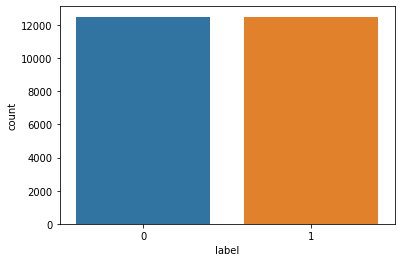

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

In [ ]:
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,PetImages/Cat/1041.jpg,0
1,PetImages/Dog/6380.jpg,1
2,PetImages/Cat/3973.jpg,0
3,PetImages/Dog/11850.jpg,1
4,PetImages/Cat/7867.jpg,0


In [ ]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
            Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
            MaxPool2D((2,2)),
            Conv2D(32, (3,3), activation='relu'),
            MaxPool2D((2,2)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPool2D((2,2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
 6/40 [===>..........................] - ETA: 6:59 - loss: 0.9201 - accuracy: 0.4919

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

40/40 [==============================] - 497s 12s/step - loss: 0.7275 - accuracy: 0.5139 - val_loss: 0.6837 - val_accuracy: 0.5822
Epoch 2/10
40/40 [==============================] - 505s 13s/step - loss: 0.6475 - accuracy: 0.6293 - val_loss: 0.6325 - val_accuracy: 0.6320
Epoch 3/10
40/40 [==============================] - 504s 12s/step - loss: 0.6082 - accuracy: 0.6692 - val_loss: 0.5723 - val_accuracy: 0.6988
Epoch 4/10
40/40 [==============================] - 505s 13s/step - loss: 0.5803 - accuracy: 0.6935 - val_loss: 0.5692 - val_accuracy: 0.7016
Epoch 5/10
40/40 [==============================] - 473s 12s/step - loss: 0.5457 - accuracy: 0.7191 - val_loss: 0.5161 - val_accuracy: 0.7378
Epoch 6/10
40/40 [==============================] - 462s 11s/step - loss: 0.5272 - accuracy: 0.7357 - val_loss: 0.5084 - val_accuracy: 0.7478
Epoch 7/10
40/40 [==============================] - 456s 11s/step - loss: 0.5289 - accuracy: 0.7331 - val_loss: 0.4923 - val_accuracy: 0.7594
Epoch 8/10
40/40 

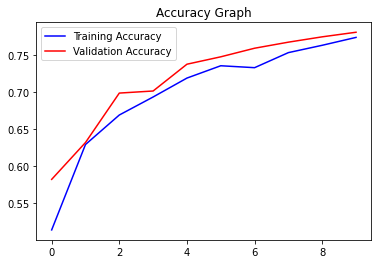

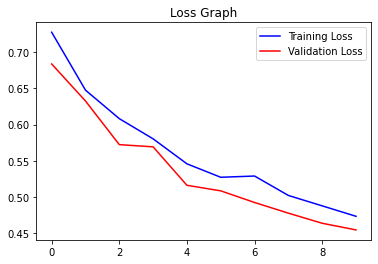

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()